In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline

# Load dataset
df = pd.read_csv('/content/Preprocessed Fake Reviews Detection Dataset.csv')
df = df.dropna(subset=['text_'])  # Remove missing values

# Data Augmentation using GPT-2
generator = pipeline("text-generation", model="gpt2")

def generate_fake_review():
    prompt = "This product is absolutely amazing because"
    generated_text = generator(prompt, max_length=50, num_return_sequences=1)
    return generated_text[0]['generated_text'].strip()

def generate_real_review():
    prompt = "As a satisfied customer, I think this product"
    generated_text = generator(prompt, max_length=50, num_return_sequences=1)
    return generated_text[0]['generated_text'].strip()

# Generate synthetic reviews
fake_reviews = [generate_fake_review() for _ in range(100)]
real_reviews = [generate_real_review() for _ in range(100)]

# Create DataFrames for synthetic reviews
fake_df = pd.DataFrame({'text_': fake_reviews, 'label': 0})  # Fake = 0
real_df = pd.DataFrame({'text_': real_reviews, 'label': 1})  # Real = 1

# Merge with original dataset
df_augmented = pd.concat([df, fake_df, real_df], ignore_index=True)
df_augmented.to_csv('/content/Augmented_Fake_Reviews.csv', index=False)

print("Augmented dataset created with synthetic fake & real reviews!")

# Features and labels
X = df_augmented['text_'].values
y = df_augmented['label'].values

# Tokenization
max_words = 10000  # Limit vocabulary size
max_len = 100  # Max review length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

# Define LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eo

Augmented dataset created with synthetic fake & real reviews!
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 258s 245ms/step - accuracy: 0.8240 - loss: 0.3846 - val_accuracy: 0.9310 - val_loss: 0.1755
Epoch 2/2
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 253s 249ms/step - accuracy: 0.9492 - loss: 0.1407 - val_accuracy: 0.9345 - val_loss: 0.1686
254/254 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step
Accuracy: 0.9345391903531438
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      4064
           1       0.94      0.93      0.93      4063

    accuracy                           0.93      8127
   macro avg       0.93      0.93      0.93      8127
weighted avg       0.93      0.93      0.93      8127



/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


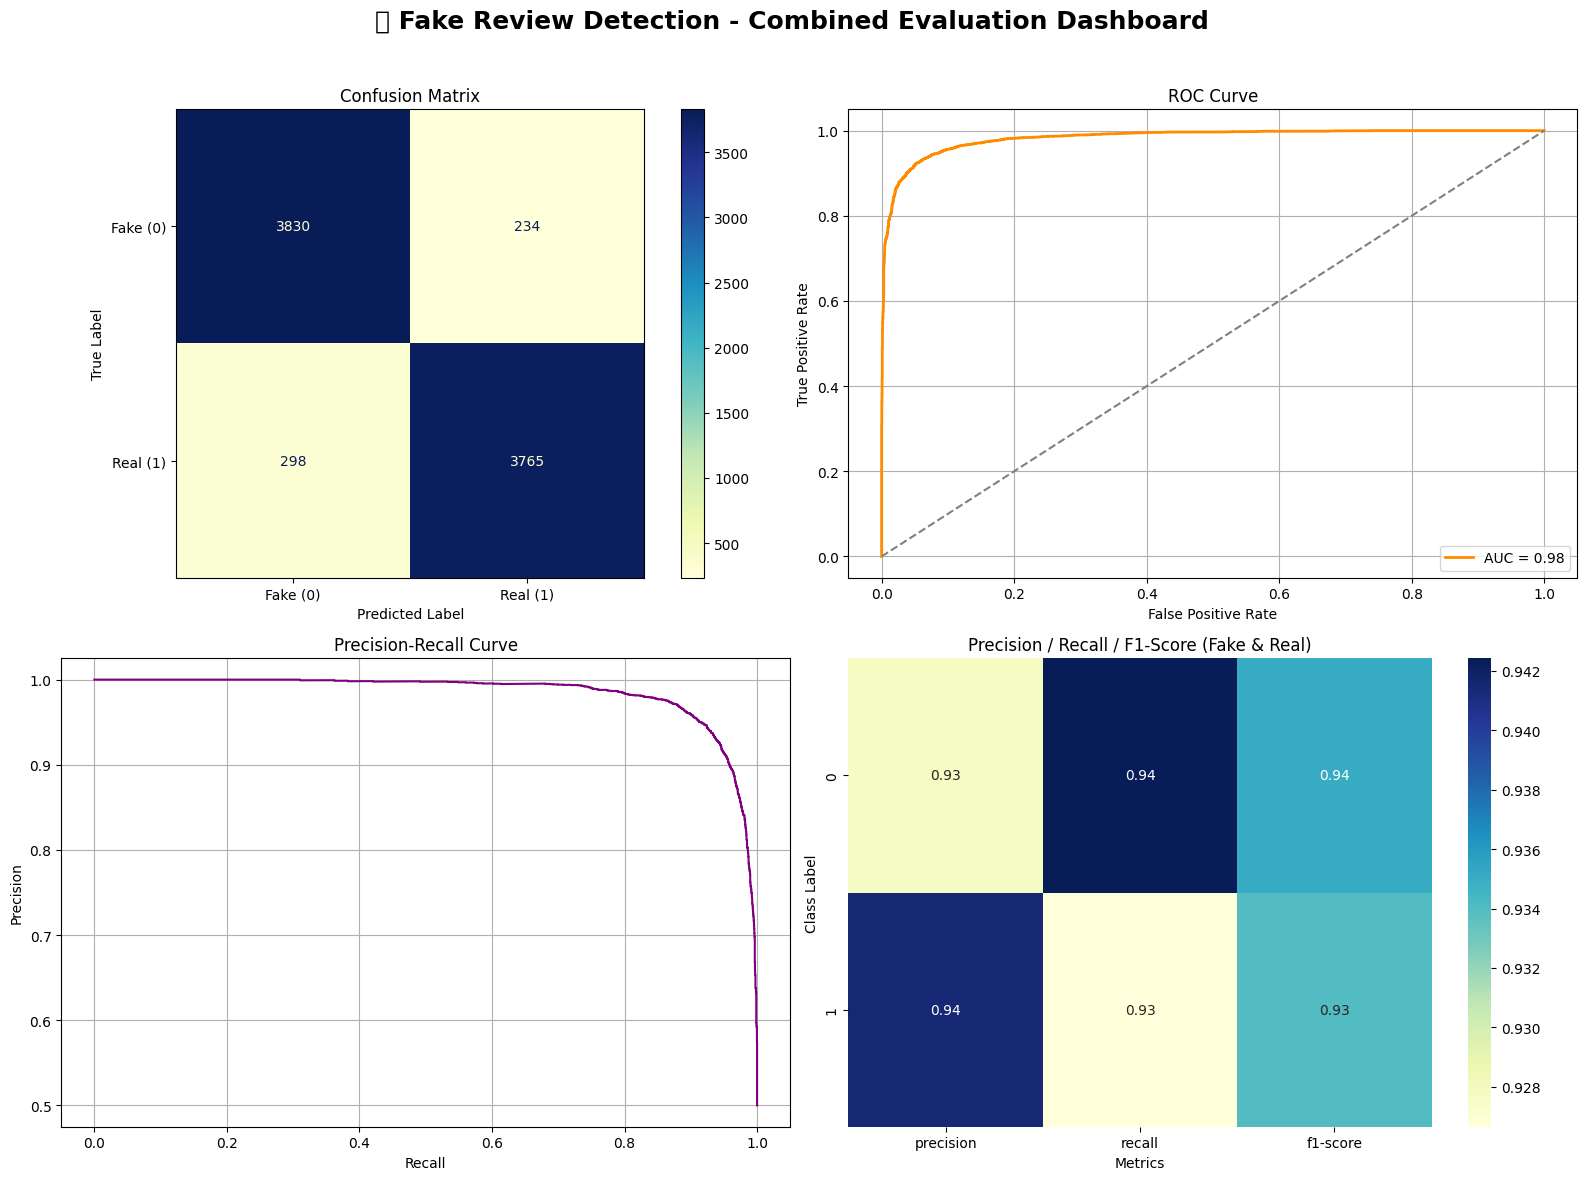

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve,
    classification_report
)

# Compute Metrics
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

#Combined Plot
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Fake Review Detection - Combined Evaluation Dashboard', fontsize=18, fontweight='bold')

# 1. Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake (0)', 'Real (1)'])
disp.plot(ax=axs[0, 0], cmap='YlGnBu', values_format='d')
axs[0, 0].set_title('Confusion Matrix')
axs[0, 0].set_xlabel('Predicted Label')
axs[0, 0].set_ylabel('True Label')

# 2. ROC Curve
axs[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
axs[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0, 1].set_title('ROC Curve')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].legend(loc='lower right')
axs[0, 1].grid(True)

# 3. Precision-Recall Curve
axs[1, 0].plot(recall, precision, color='purple')
axs[1, 0].set_title('Precision-Recall Curve')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].grid(True)

# 4. Classification Report Heatmap
sns.heatmap(df_report.iloc[:2, :3], annot=True, fmt=".2f", cmap='YlGnBu', ax=axs[1, 1])
axs[1, 1].set_title('Precision / Recall / F1-Score (Fake & Real)')
axs[1, 1].set_xlabel('Metrics')
axs[1, 1].set_ylabel('Class Label')

# Final Layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
